In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np

from utils.conn_data import load_pickle
from utils.diagnostics import compute_summary_statistics

plt.style.use('ggplot')

In [2]:
inputs_path = os.path.join(os.getcwd(), "data", "inputs")
outputs_path = os.path.join(os.getcwd(), "data", "outputs")
forecast_input = "wrds_etf_returns"
memory_input = "fredmd_transf"
vol_target = 0.15
portfolio_methods = [
    "naive",
    #"weighted-naive",
    "linear-ridge",
    "mvo",
    "bl"
]

In [3]:
# load memory data and preprocess
memory_data = pd.read_csv(os.path.join(inputs_path, f'{memory_input}.csv'))

## fix dates
memory_data["date"] = pd.to_datetime(memory_data["date"])
memory_data = memory_data.set_index("date")
memory_data = memory_data.astype(float)

# fill missing values
memory_data = memory_data.interpolate(method='linear', limit_direction='forward', axis=0)
memory_data = memory_data.ffill()
memory_data = memory_data.bfill()

## compute moving average
memory_data = memory_data.rolling(window=12).mean()

## drop missing values
memory_data = memory_data.dropna()

returns = pd.read_csv(os.path.join(inputs_path, f'{forecast_input}.csv'))
returns = returns[[col for col in returns.columns if "t+1" not in col]]

## fix dates
returns["date"] = pd.to_datetime(returns["date"])
returns["date"] = returns["date"] + pd.DateOffset(months=1)
returns = returns.set_index("date")
memory_data = memory_data.astype(float)

## resample and match memory data dates
returns = returns.resample("MS").last().ffill()
returns = pd.merge(returns, memory_data[[memory_data.columns[0]]], left_index=True, right_index=True).drop(memory_data.columns[0], axis=1)

## drop missing values
returns = returns.dropna()

In [4]:
# get regimes
memory_dir_name = "kmeans_elbow"
memory_results_path = os.path.join("data", "inputs", "memory", memory_dir_name, "results.pkl")
memory_results = pd.read_pickle(memory_results_path)
regimes = memory_results["regimes"]
centroids = memory_results["centroids"]
regimes_probs = memory_results["regimes_probs"]

In [5]:
pd.DataFrame(memory_data.columns)

0
0                RPI
1            W875RX1
2    DPCERA3M086SBEA
3          CMRMTSPLx
4            RETAILx
..               ...
122    CUSR0000SA0L5
123            PCEPI
124  DDURRG3M086SBEA
125  DNDGRG3M086SBEA
126  DSERRG3M086SBEA

[127 rows x 1 columns]

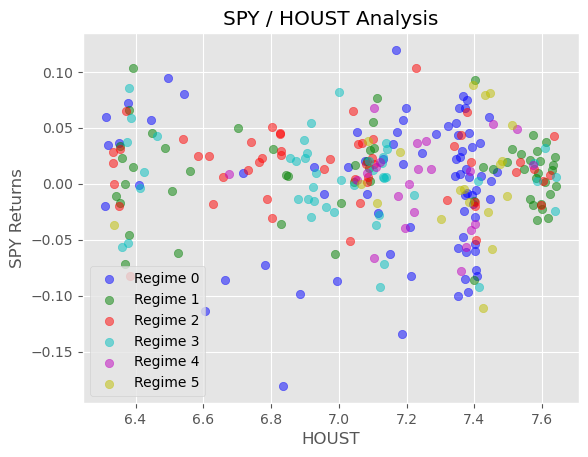

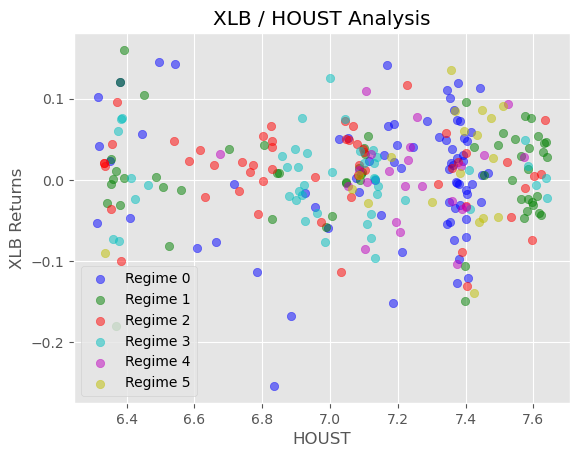

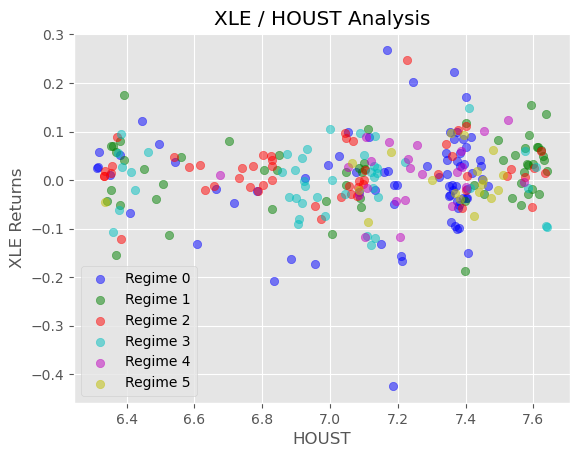

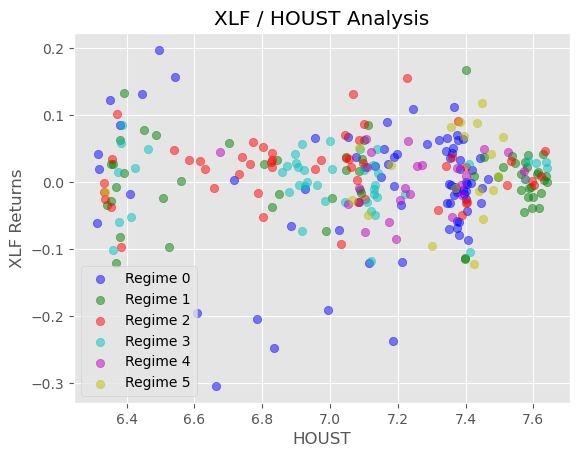

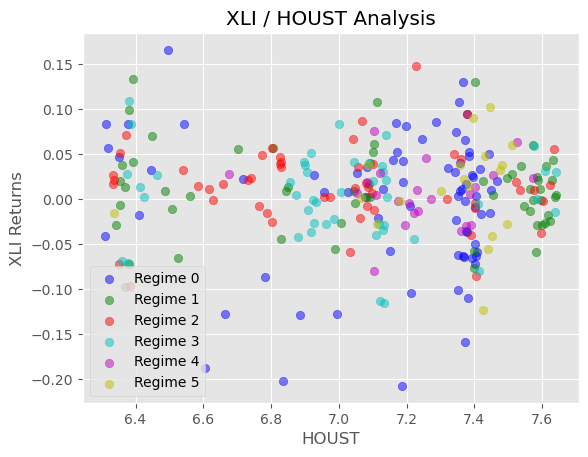

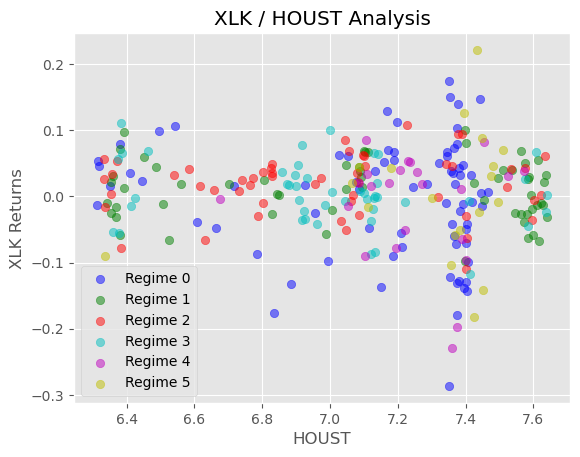

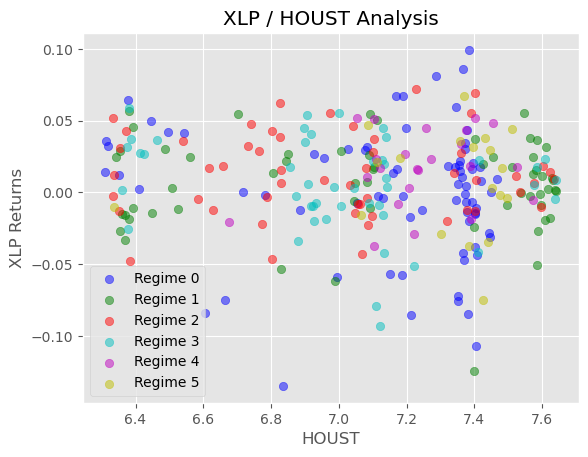

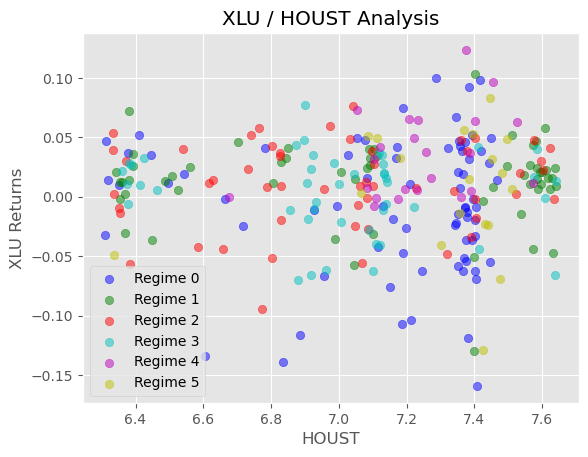

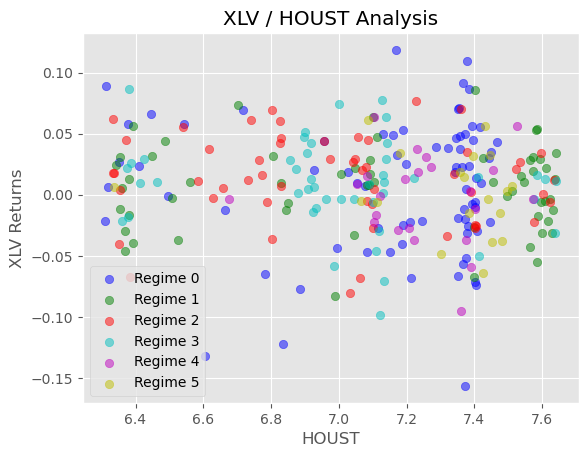

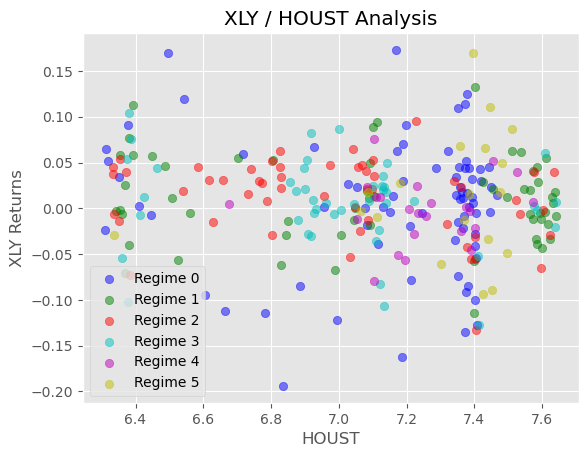

In [6]:
etfs = ['SPY', 'XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
macro_var = 'HOUST'

for etf in etfs:
    plt.clf()
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    for i in range(6):
        plt.scatter(memory_data[-276:-1][macro_var][regimes[-275:]['cluster_step697'] == i], returns[etf][regimes[-275:]['cluster_step697'] == i], c=colors[i], label=f"Regime {i}", alpha=0.5)
    plt.title(f"{etf} / {macro_var} Analysis")
    plt.xlabel(macro_var)
    plt.ylabel(etf + " Returns")
    plt.legend()
    plt.show()

In [7]:
all_portfolio_returns = []
colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k']
line_types = ['-', '--', '-.', ':']
styles = ['m', 'c']
for method in portfolio_methods:
    cur_color = colors.pop(0)
    dirs = os.listdir(os.path.join(outputs_path, method))

    for i, dir in enumerate(dirs):
        cur_line_type = line_types[i % len(line_types)]
        styles.append(f"{cur_color}{cur_line_type}")
        # print(method, dir)

        try:
            results = load_pickle(os.path.join(outputs_path, method, dir))
        except:
            print(method, dir)
            continue

        # get forecasts
        forecasts = results['forecasts']
        forecasts.index = pd.to_datetime(forecasts.index)
        forecasts.index.name = "date"

        # check which dataframe haas the smallest number of rows and match dates
        if len(forecasts) < len(returns):
            returns = returns.loc[forecasts.index[0]:forecasts.index[-1]]
        else:
            forecasts = forecasts.loc[returns.index[0]:returns.index[-1]]

        # match columns
        forecasts = forecasts[returns.columns]

        # portfolio returns
        portfolio_returns = forecasts.multiply(returns, axis=0)

        model_tag = dir.split('.')[0][8:]
        #long_only_tag = dir.split('.')[0].split('_')[1]
        #num_assets_tag = dir.split('.')[0].split('_')[2]
        portfolio_returns["models"] = f"{method}_{model_tag}"

        all_portfolio_returns.append(portfolio_returns.reset_index().melt(["models", "date"]))
all_portfolio_returns_df = pd.concat(all_portfolio_returns)

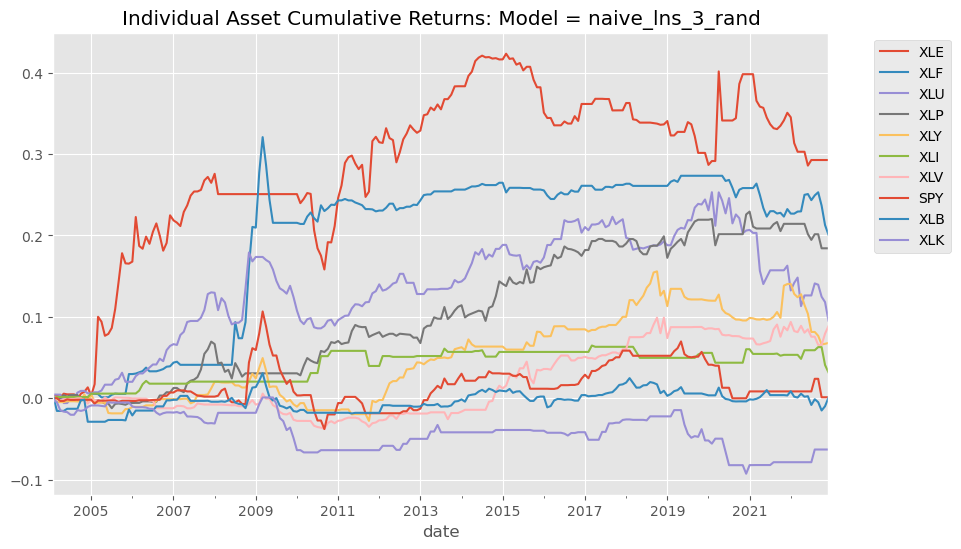

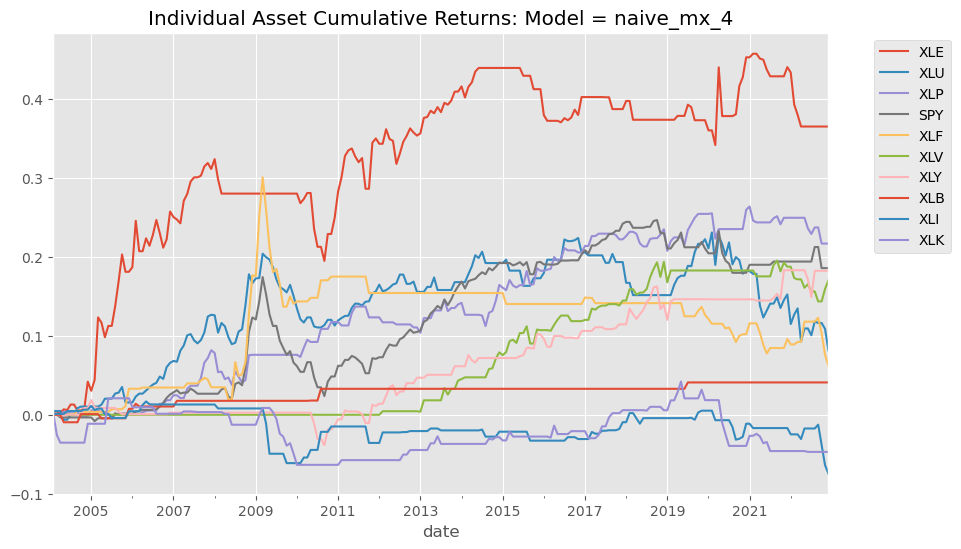

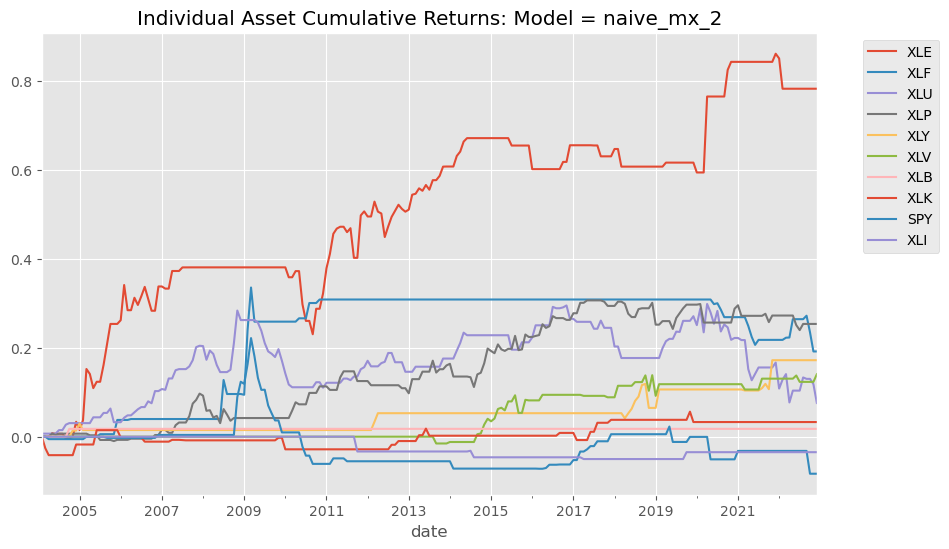

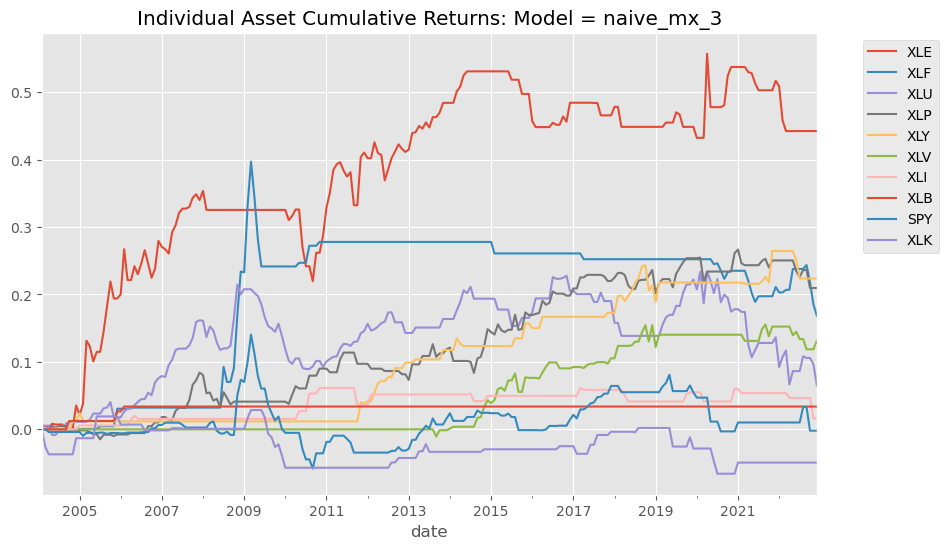

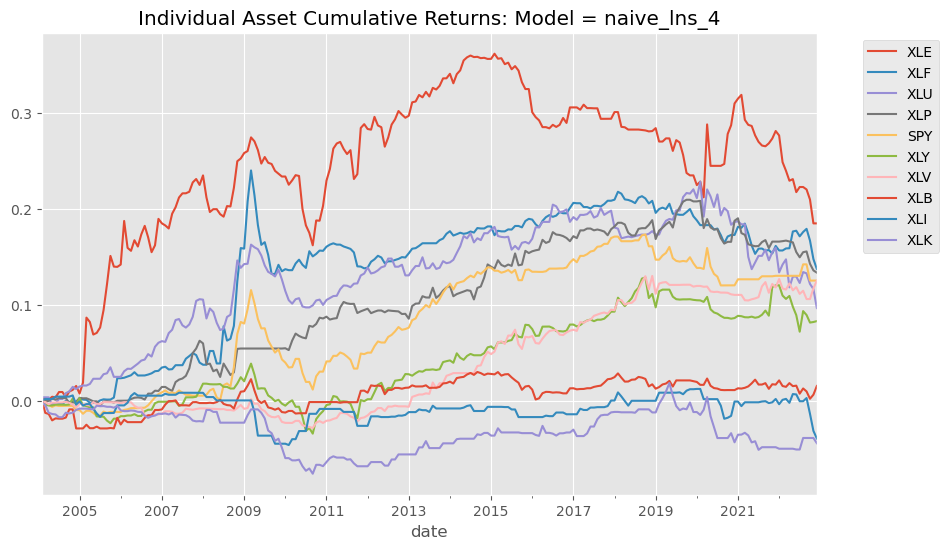

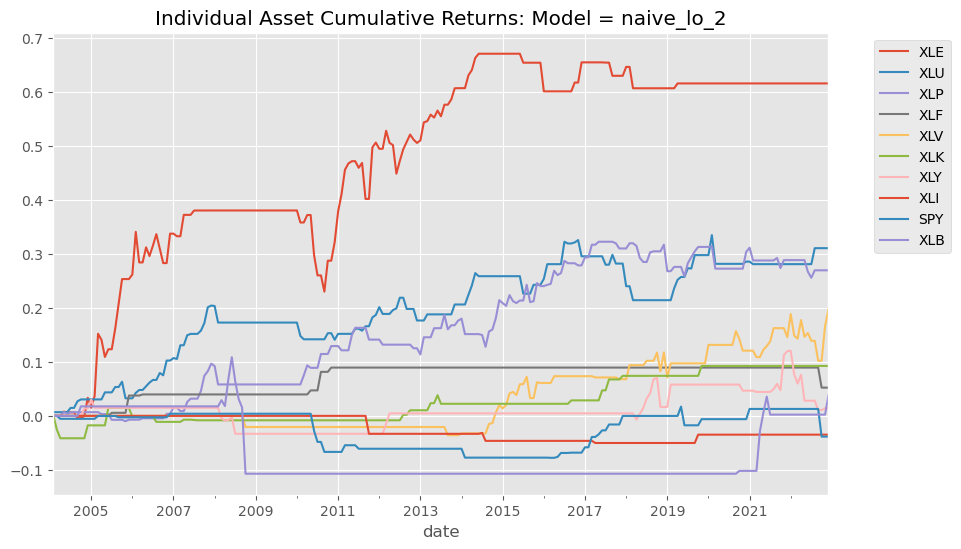

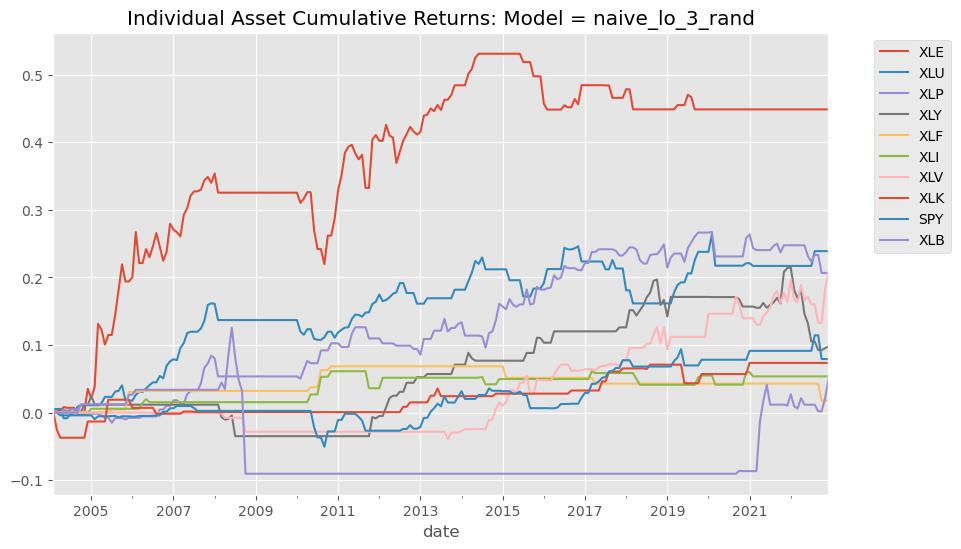

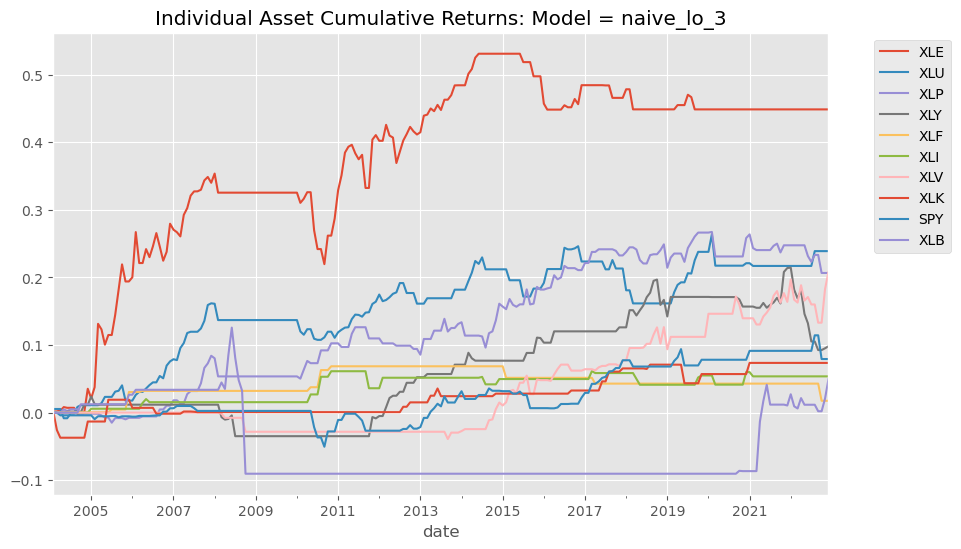

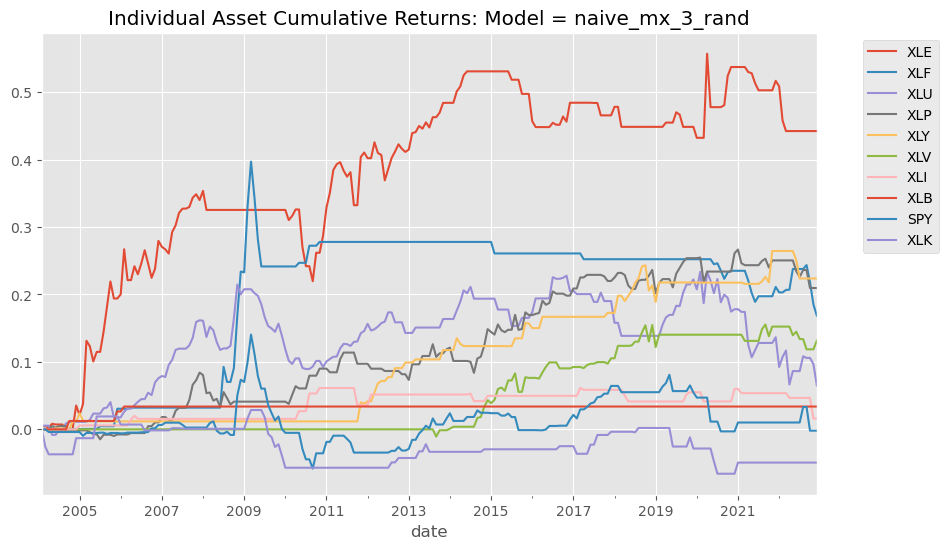

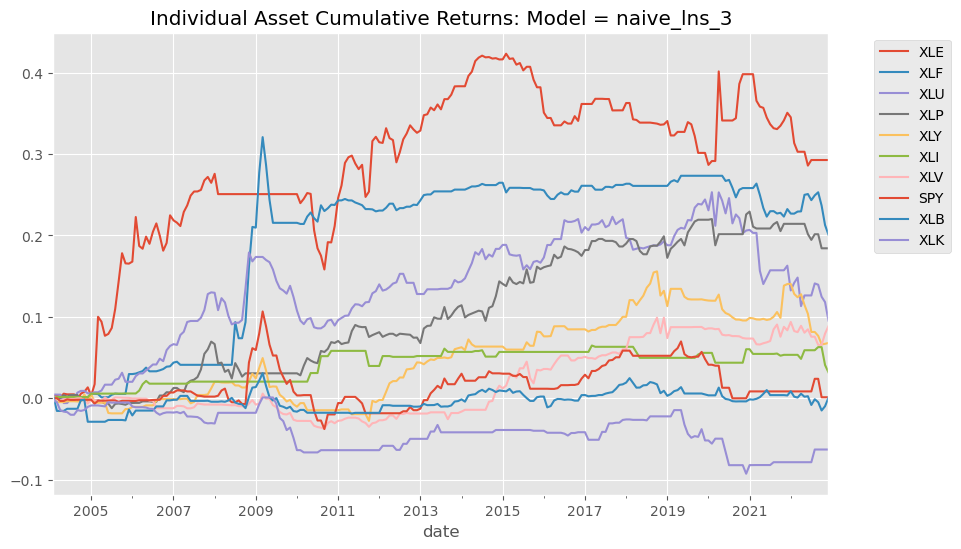

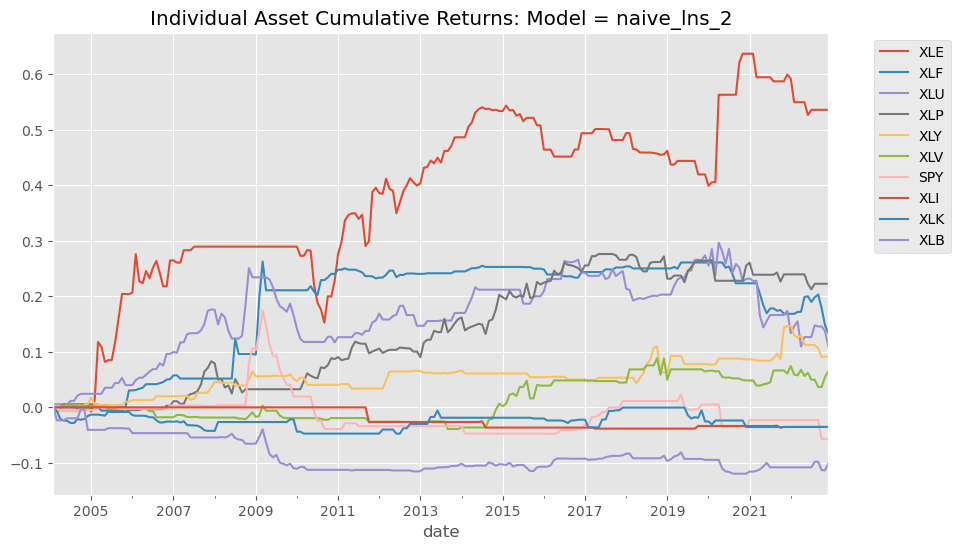

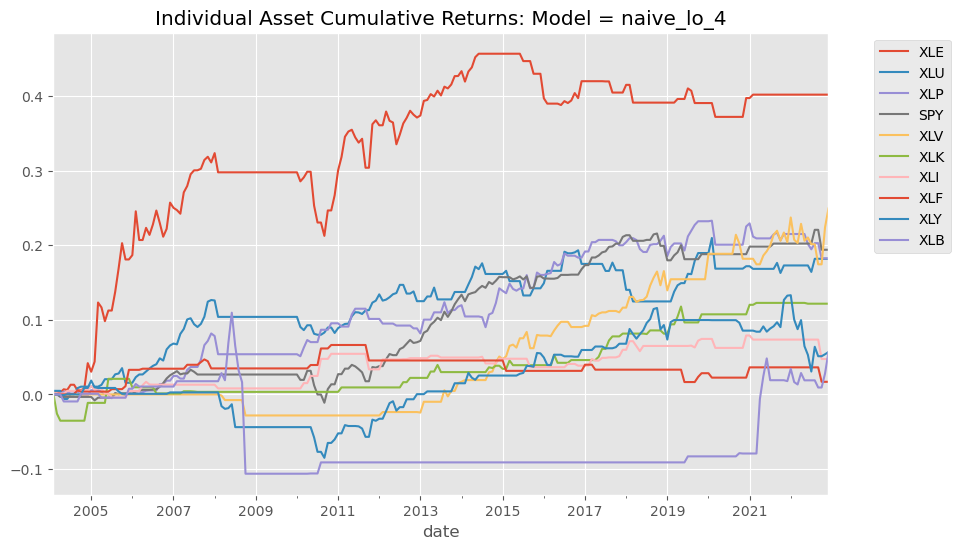

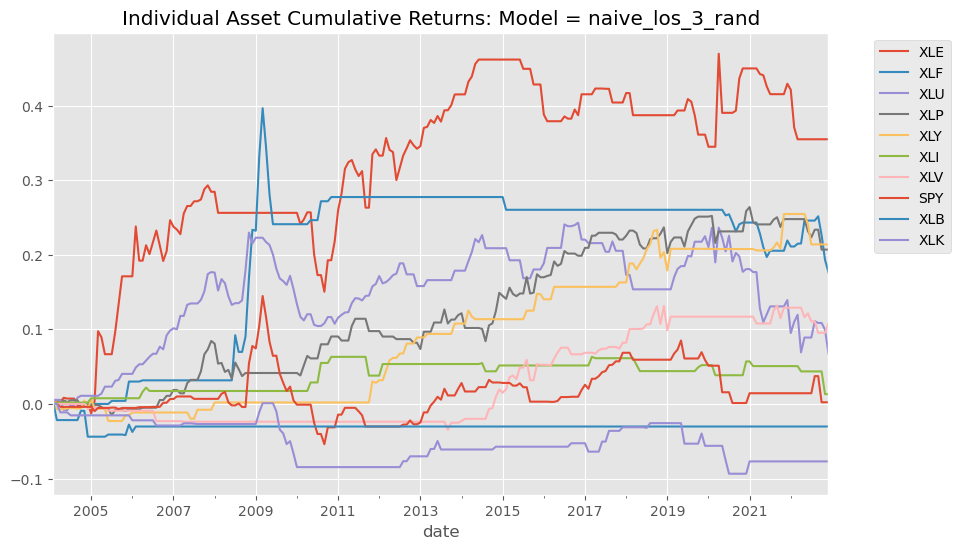

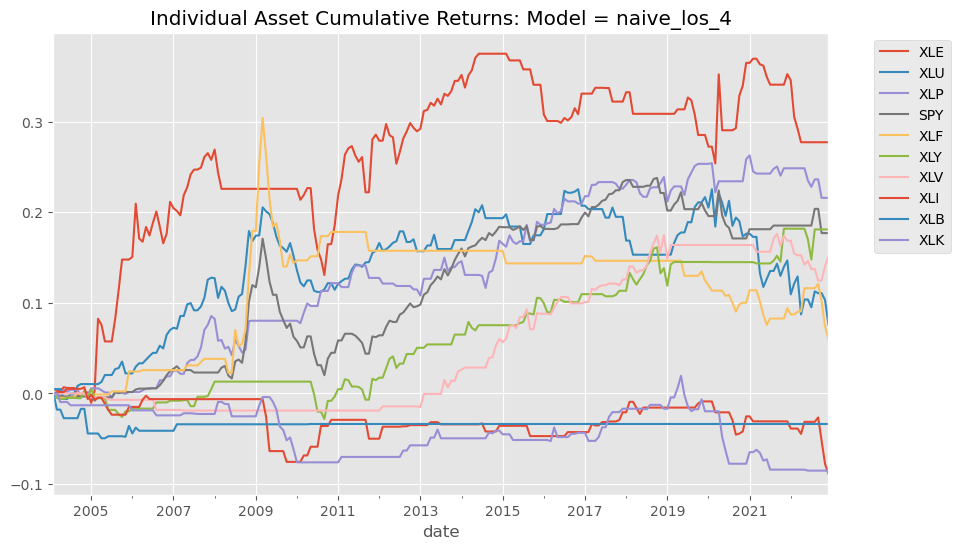

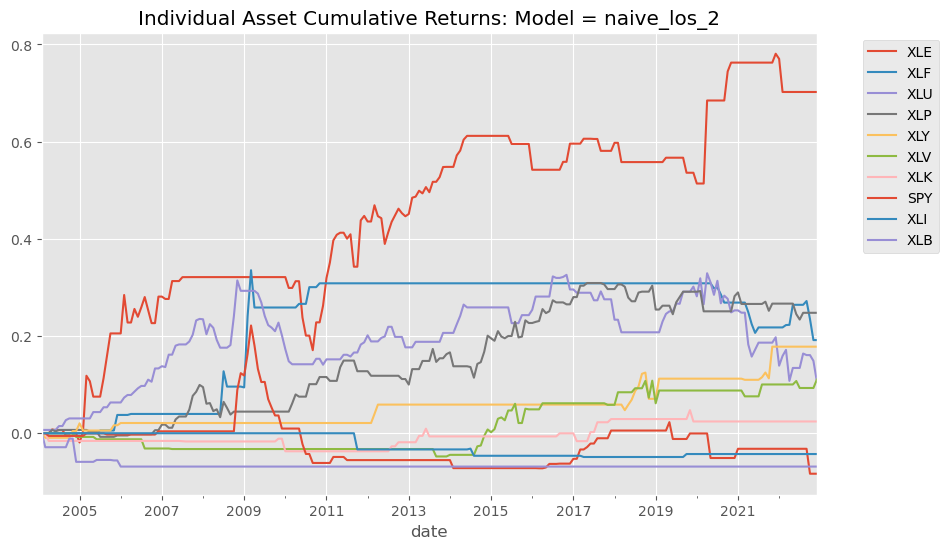

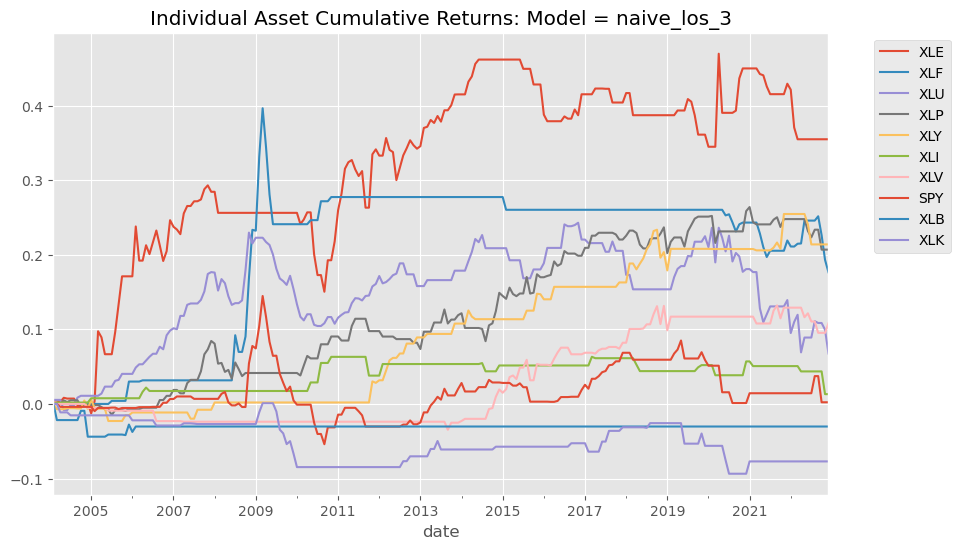

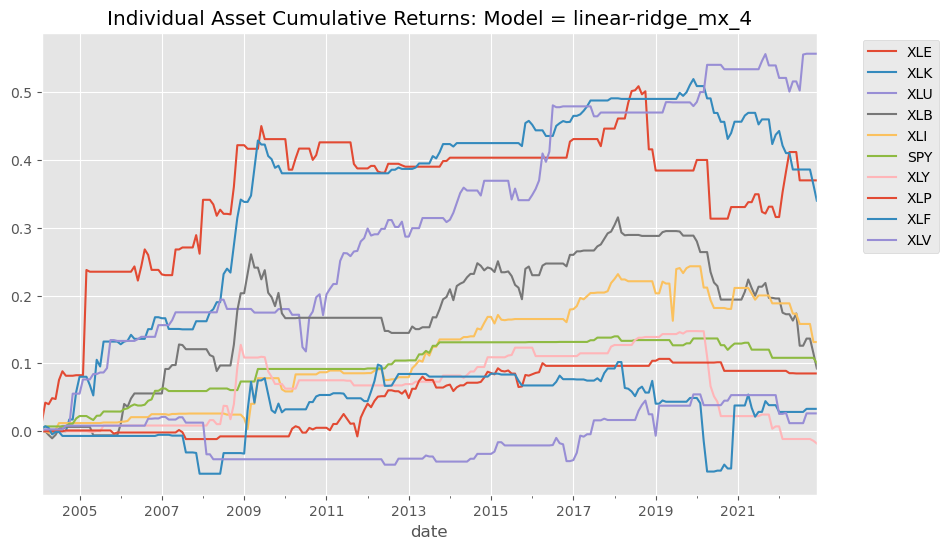

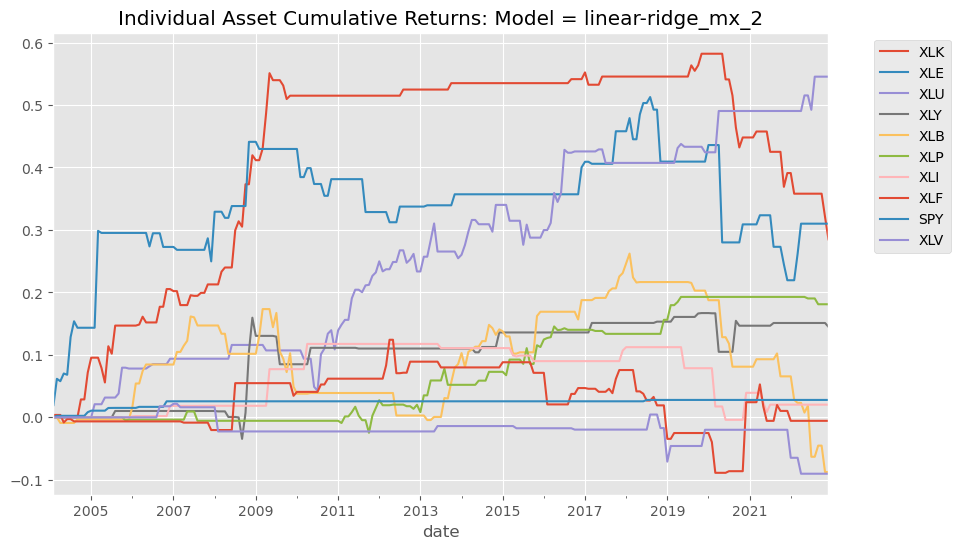

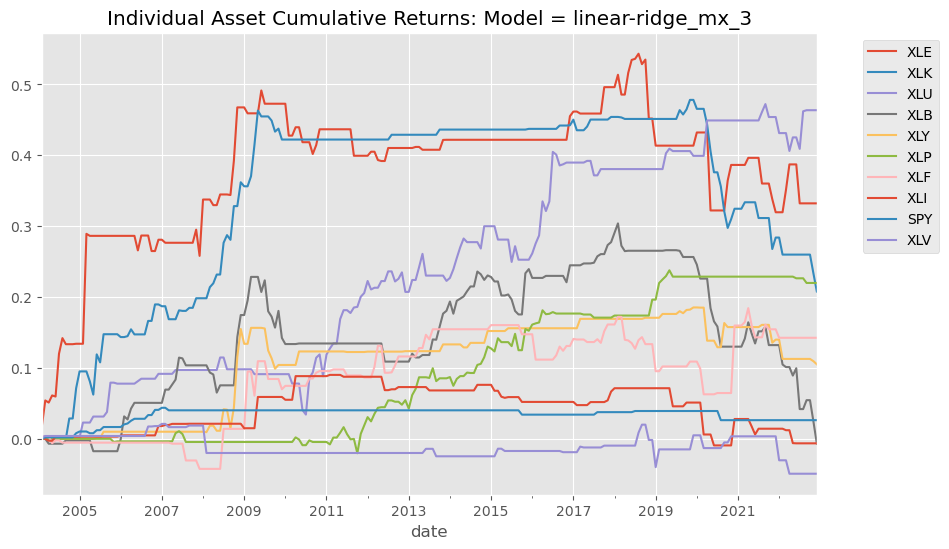

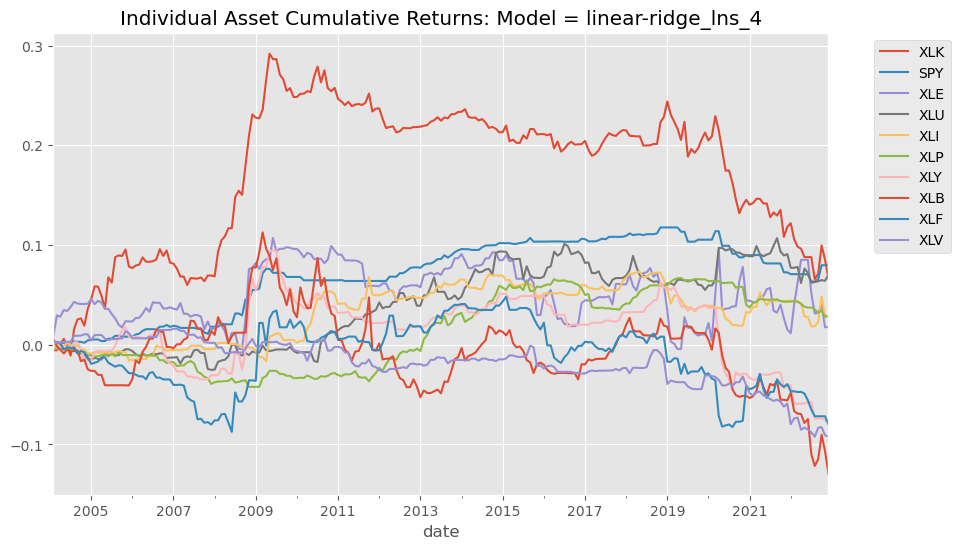

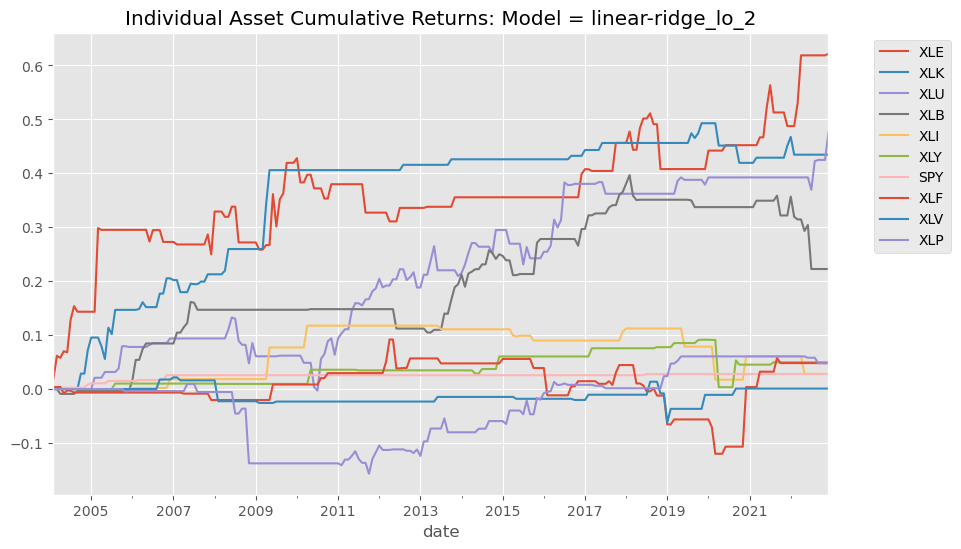

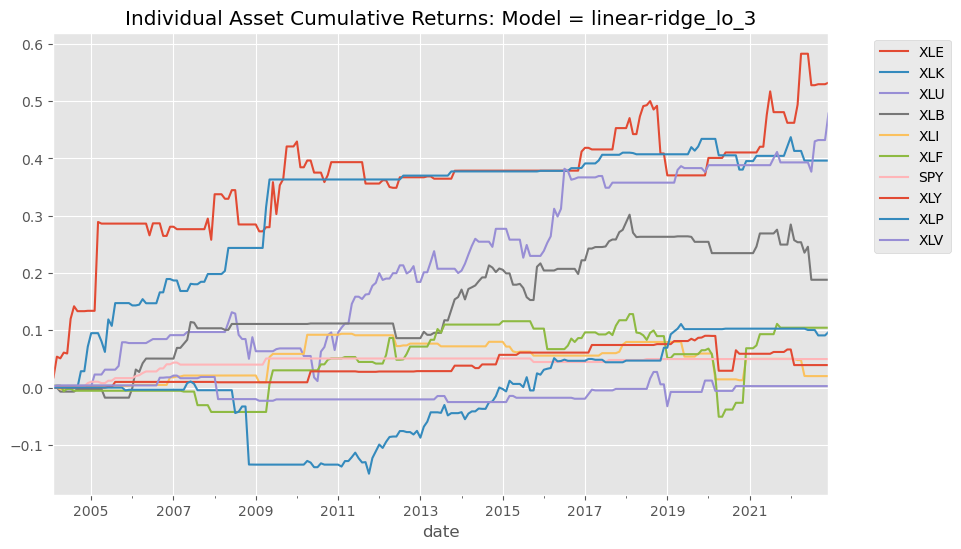

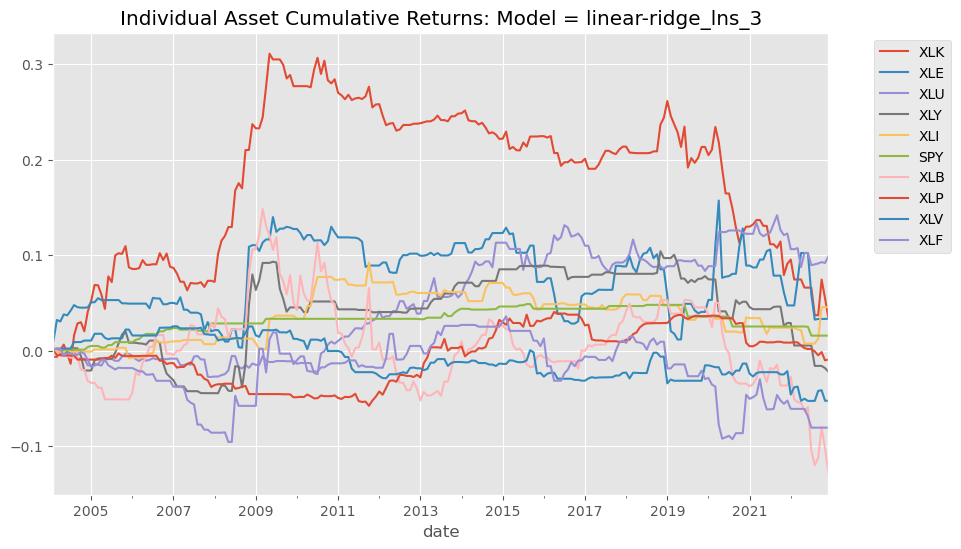

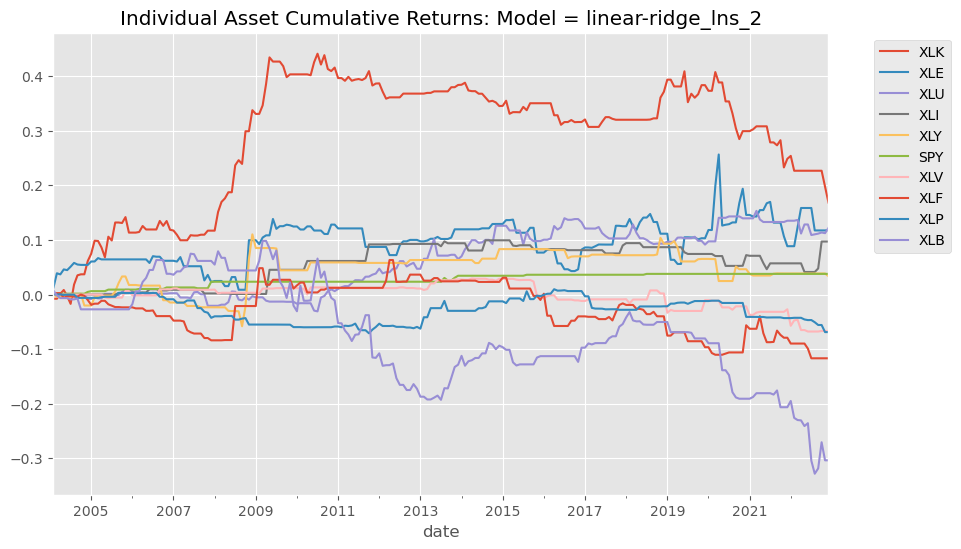

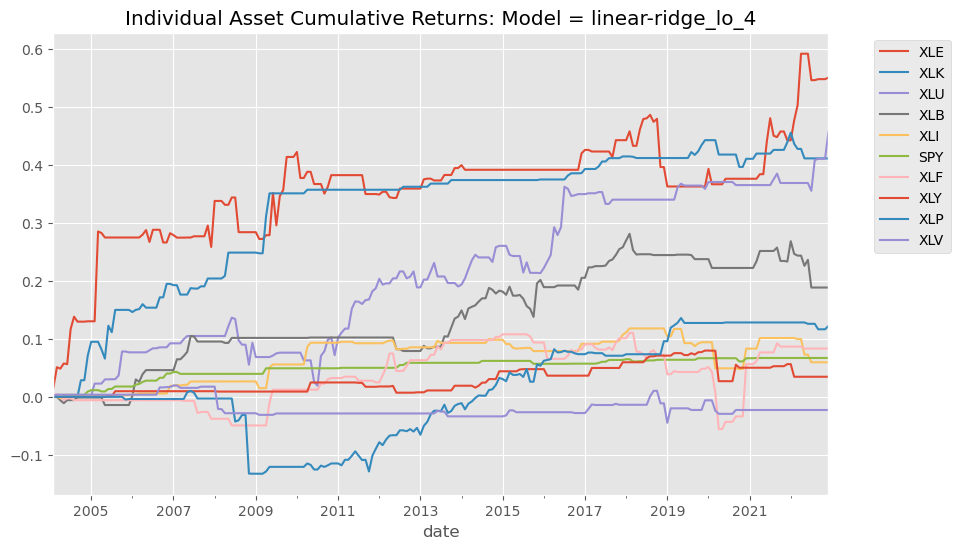

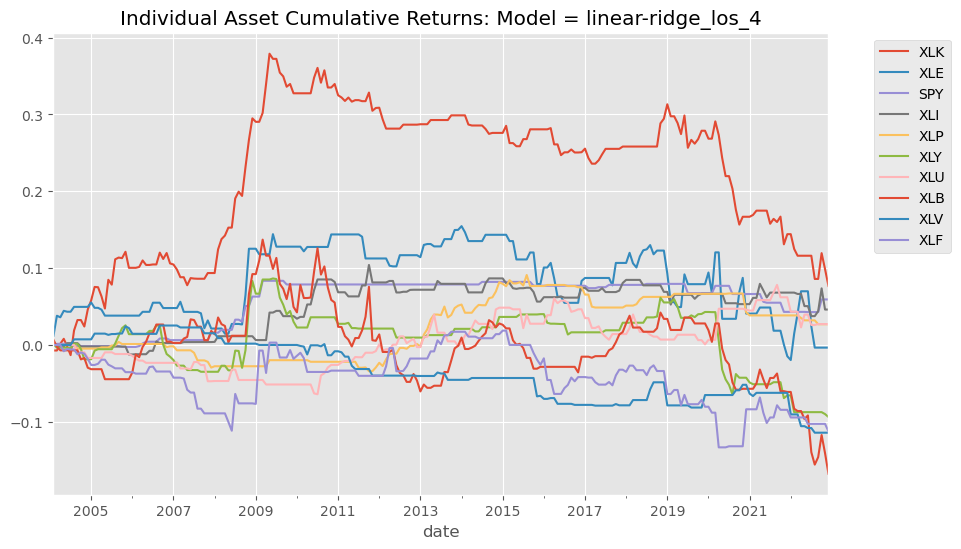

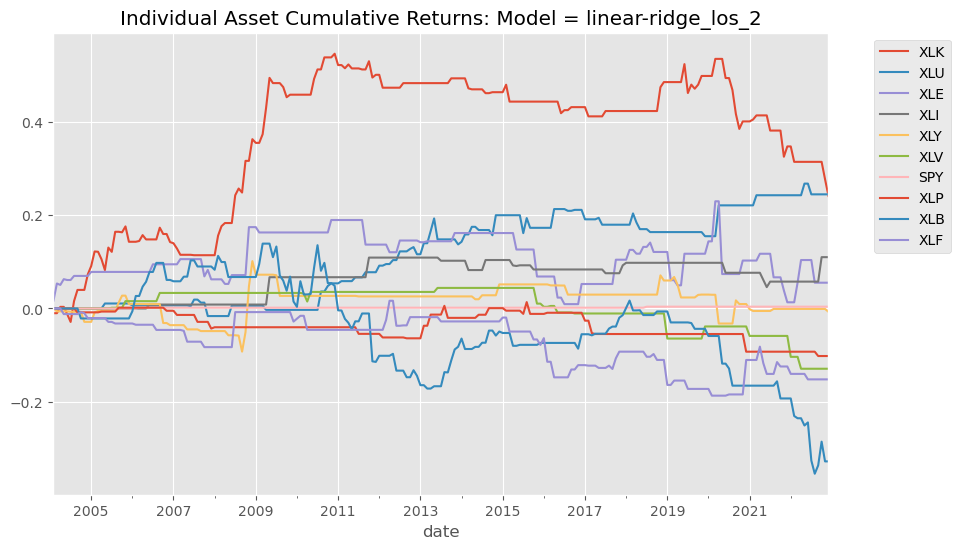

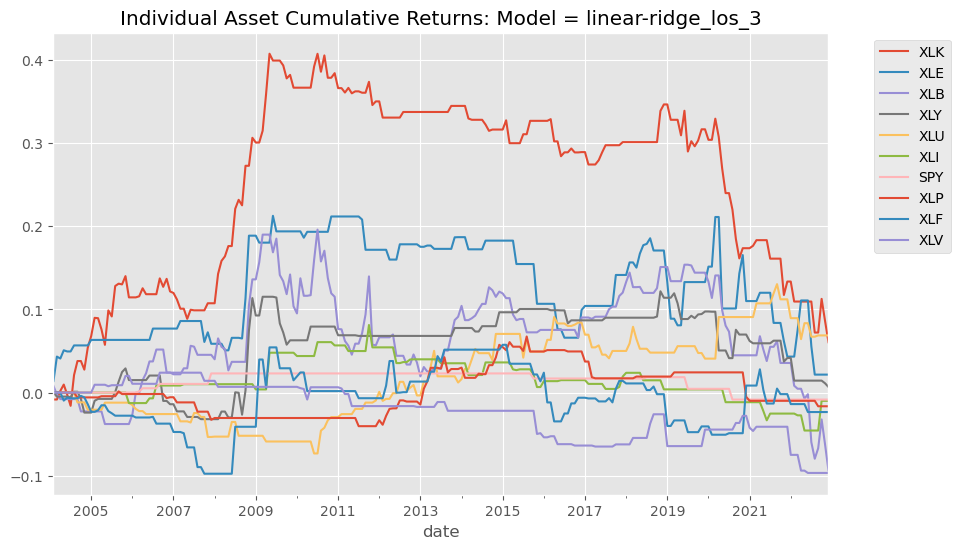

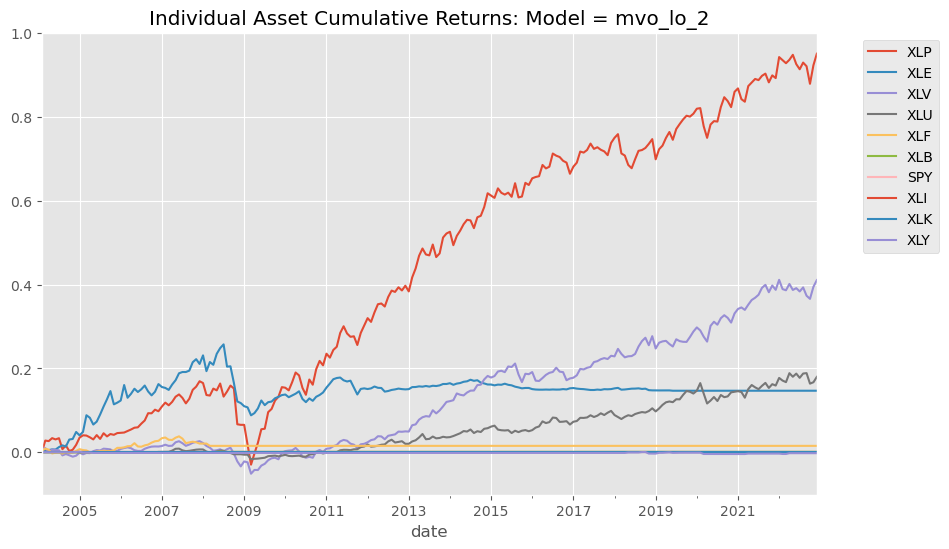

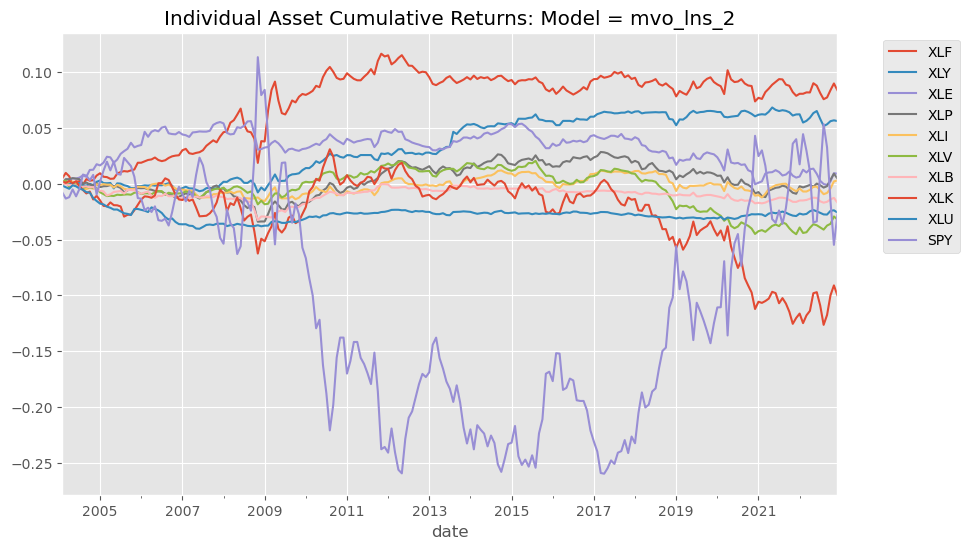

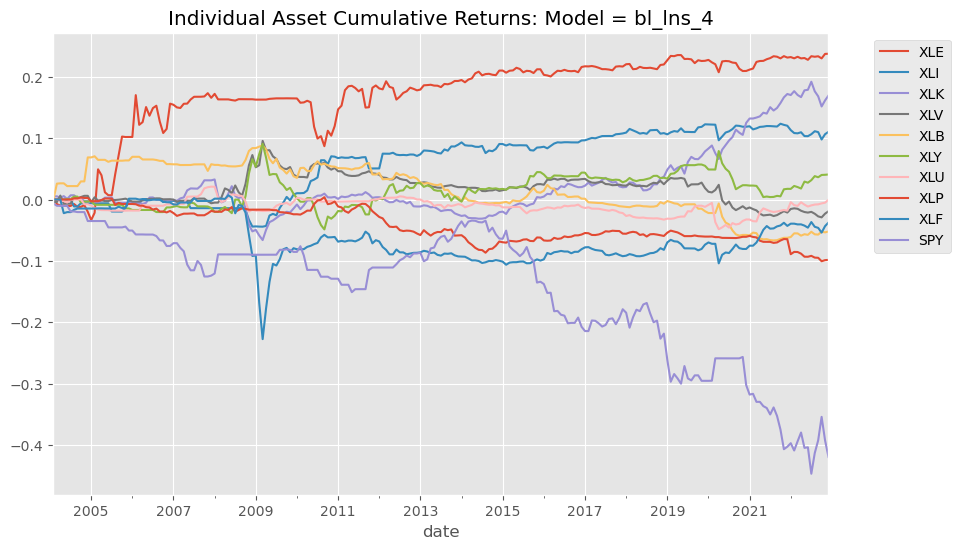

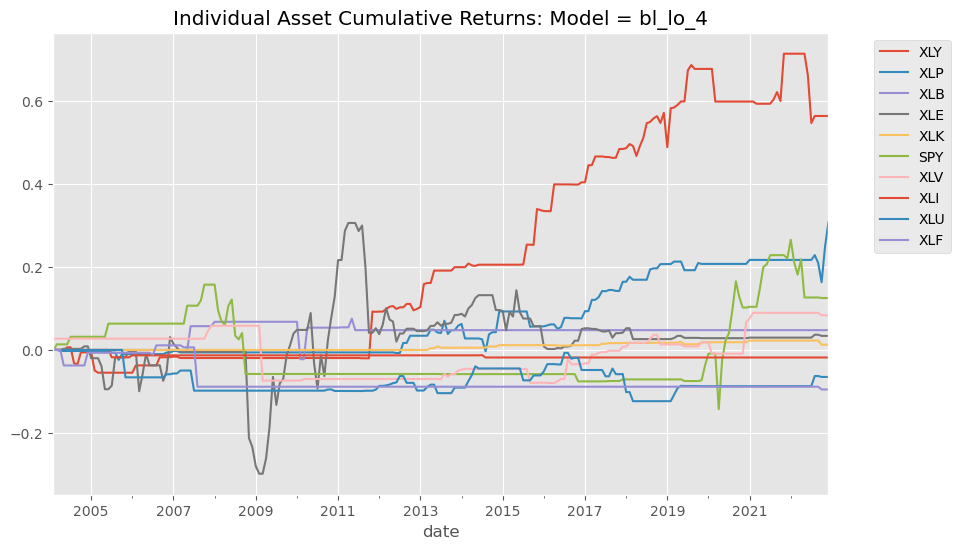

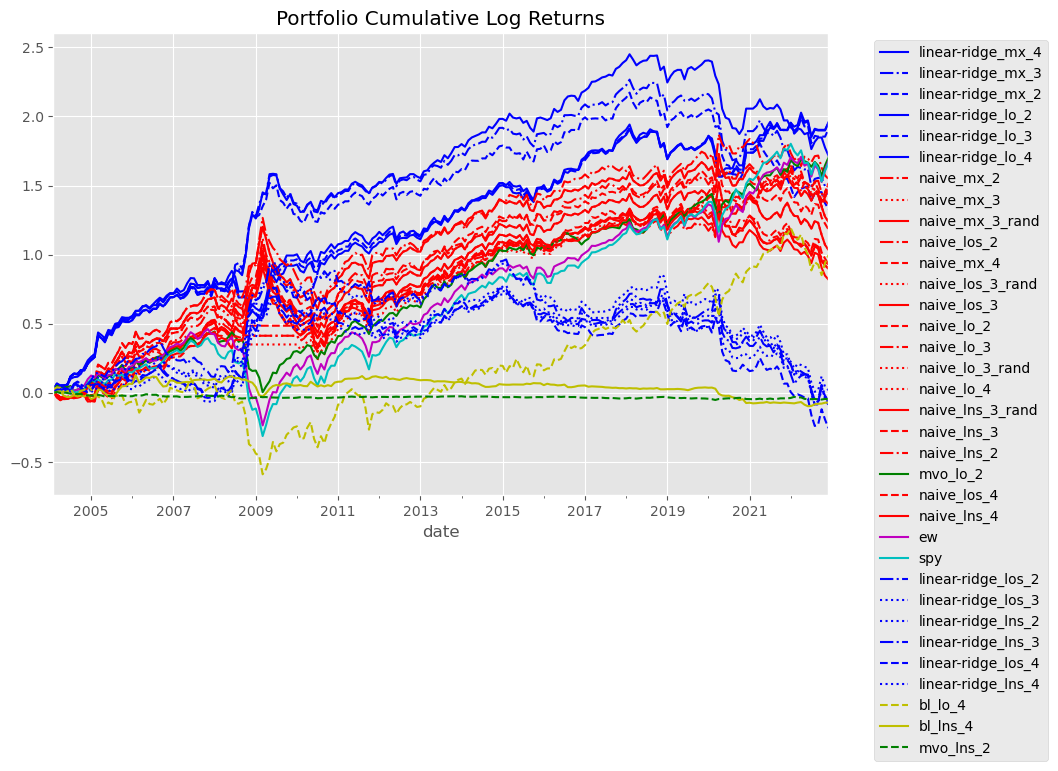

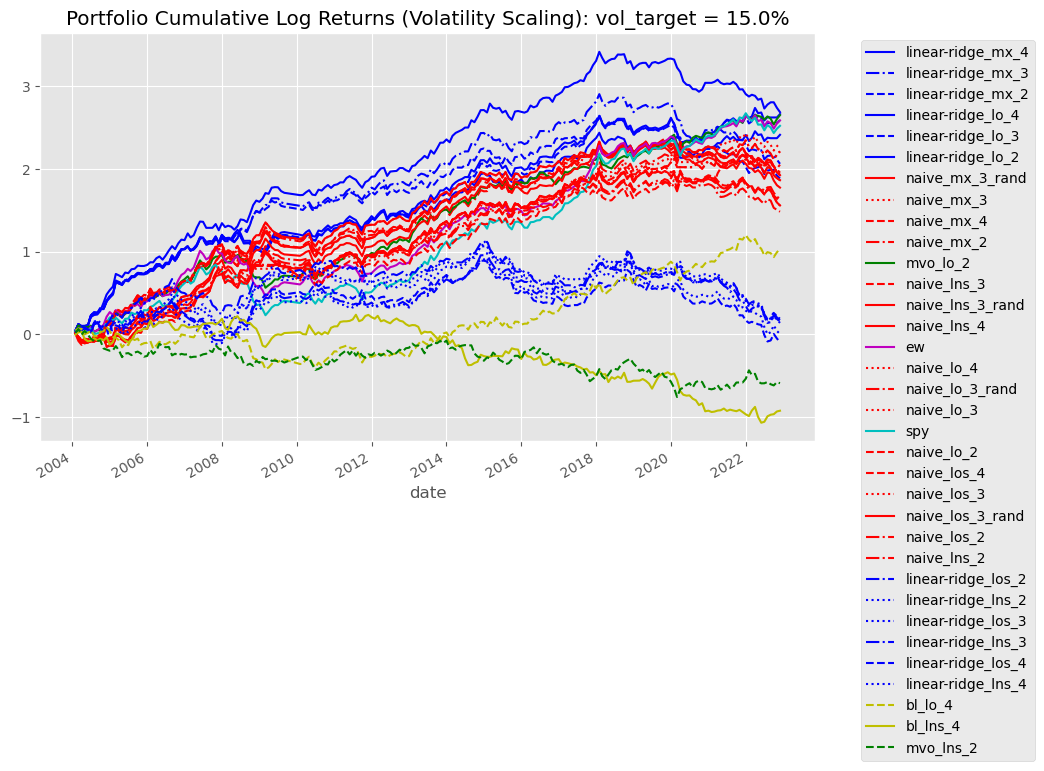

In [8]:
equal_weight_cumm_returns = pd.DataFrame(returns.mean(axis=1), columns=["ew"])
spy_cumm_returns = pd.DataFrame(pd.DataFrame(returns['SPY'], columns=["SPY"]).sum(axis=1), columns=["spy"])
concat_list = [equal_weight_cumm_returns, spy_cumm_returns]

for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")
    order = tmp_portfolio_returns.cumsum().mean(axis=0).sort_values(ascending=False).index
    ax = tmp_portfolio_returns.cumsum()[order].plot(figsize=(10, 6), title=f"Individual Asset Cumulative Returns: Model = {model}")
    
    # Place the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.show()

    # add equal weight
    concat_list.append(pd.DataFrame(tmp_portfolio_returns.sum(axis=1), columns=[model]))

cumm_returns_plot = pd.concat(concat_list, axis=1)
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
ax = cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title="Portfolio Cumulative Log Returns")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Volatility scaling
vol_target = 0.15
portfolio_vol = vol_target / (cumm_returns_plot.rolling(window=12).std().bfill() * np.sqrt(12))
cumm_returns_plot = (cumm_returns_plot * portfolio_vol).dropna()
order = cumm_returns_plot.cumsum().mean(axis=0).sort_values(ascending=False).index
order_style = list(cumm_returns_plot.cumsum().mean(axis=0).argsort())
ax = cumm_returns_plot.cumsum()[order].plot(figsize=(10, 6), style=[styles[x] for x in reversed(order_style)], title=f"Portfolio Cumulative Log Returns (Volatility Scaling): vol_target = {vol_target * 100}%")

# Place the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [9]:
# ew_vol_scale = 10 / (equal_weight_cumm_returns.rolling(window=3).std() * 12 * 100)
# tensor_scaled_equal_weight_cumm_returns = torch.tensor((equal_weight_cumm_returns * ew_vol_scale).dropna().values)
ew_summary_statistics = compute_summary_statistics(torch.tensor(equal_weight_cumm_returns.values))
ew_summary_statistics = pd.DataFrame([ew_summary_statistics], index=["EW"])

all_summary_statistics = []
for model in all_portfolio_returns_df["models"].unique():
    tmp_portfolio_returns = all_portfolio_returns_df[all_portfolio_returns_df["models"] == model]
    tmp_portfolio_returns = tmp_portfolio_returns.drop("models", axis=1).pivot_table(index="date", columns="variable", values="value")

    vol_scale = 10 / (tmp_portfolio_returns.mean(axis=1).rolling(window=3).std() * 12 * 100)
    tensor_tmp_portfolio_returns = torch.tensor((tmp_portfolio_returns.mean(axis=1) * vol_scale).dropna().values)
    summary_statistics = compute_summary_statistics(tensor_tmp_portfolio_returns)
    summary_statistics = pd.DataFrame([summary_statistics], index=[model])

    all_summary_statistics.append(summary_statistics)
all_summary_statistics_df = pd.concat(all_summary_statistics)

all_summary_statistics_df

E[R]     Std(R)    Sharpe   Sortino      AvgDD  \
naive_lns_3_rand    3.783684  14.497488  0.904092  1.852902  -2.094940   
naive_mx_4          3.945650  20.645385  0.662043  1.944809  -2.286264   
naive_mx_2          4.139033  25.038304  0.572644  1.025091  -4.173809   
naive_mx_3          2.900854  13.704210  0.733268  1.216289  -2.625975   
naive_lns_4         2.502151  19.603486  0.442151  0.413192  -3.323573   
naive_lo_2          5.558100  22.819801  0.843733  3.671320  -1.115055   
naive_lo_3_rand     4.089156  11.922358  1.188125  2.765341  -0.918933   
naive_lo_3          4.089156  11.922358  1.188125  2.765341  -0.918933   
naive_mx_3_rand     2.900854  13.704210  0.733268  1.216289  -2.625975   
naive_lns_3         3.783684  14.497488  0.904092  1.852902  -2.094940   
naive_lns_2         4.740241  24.902382  0.659402  1.939702  -2.334957   
naive_lo_4          5.126246  19.867086  0.893832  3.346403  -0.903580   
naive_los_3_rand    2.419685  13.943328  0.601150  0.975761  -2.710280   
naive_los_4         3.439052  20.860382  0.571093  1.558876  -2.509046   
naive_los_2         3.739181  24.906763  0.520056  0.930919  -4.191257   
naive_los_3         2.419685  13.943328  0.601150  0.975761  -2.710280   
linear-ridge_mx_4   4.288117  14.841097  1.000901  2.257753  -1.707441   
linear-ridge_mx_2   2.859994  12.329606  0.803538  1.506398  -1.761696   
linear-ridge_mx_3   3.251425  13.462339  0.836650  1.744431  -1.527808   
linear-ridge_lns_4 -0.301076  17.693262 -0.058947 -0.058751 -10.770909   
linear-ridge_lo_2   4.103579  12.295885  1.156095  2.480882  -0.825626   
linear-ridge_lo_3   4.538153  13.416085  1.171774  2.504295  -0.852433   
linear-ridge_lns_3  0.926468  18.346730  0.174929  0.311123  -8.616107   
linear-ridge_lns_2  0.169495  19.034424  0.030847  0.048483 -10.434762   
linear-ridge_lo_4   4.782012  13.633499  1.215049  2.616443  -0.851374   
linear-ridge_los_4 -0.474583  15.103023 -0.108853 -0.128392 -11.376491   
linear-ridge_los_2  0.601895  13.302892  0.156735  0.290064  -4.788242   
linear-ridge_los_3  0.250268  15.594213  0.055594  0.072532  -7.757119   
mvo_lo_2            4.187611  12.916239  1.123106  2.033201  -0.922407   
mvo_lns_2          -0.058353  11.840279 -0.017072 -0.029242  -4.241628   
bl_lns_4           -1.131179  12.100013 -0.323844 -0.486332 -10.778028   
bl_lo_4             1.951133  23.827858  0.283656  0.218267  -7.305618   

                        MaxDD  % Positive Ret.  
naive_lns_3_rand    -9.892407         0.577778  
naive_mx_4         -12.242555         0.564444  
naive_mx_2         -20.045172         0.582222  
naive_mx_3         -14.102918         0.573333  
naive_lns_4        -16.489205         0.560000  
naive_lo_2          -5.759782         0.560000  
naive_lo_3_rand     -4.798737         0.551111  
naive_lo_3          -4.798737         0.551111  
naive_mx_3_rand    -14.102918         0.573333  
naive_lns_3         -9.892407         0.577778  
naive_lns_2        -11.576894         0.582222  
naive_lo_4          -4.798737         0.563063  
naive_los_3_rand   -14.102918         0.564444  
naive_los_4        -12.242555         0.555556  
naive_los_2        -20.045172         0.577778  
naive_los_3        -14.102918         0.564444  
linear-ridge_mx_4  -10.829295         0.595556  
linear-ridge_mx_2  -11.421429         0.546667  
linear-ridge_mx_3   -9.377934         0.573333  
linear-ridge_lns_4 -23.526763         0.506667  
linear-ridge_lo_2   -3.948980         0.551111  
linear-ridge_lo_3   -5.411700         0.586667  
linear-ridge_lns_3 -18.965711         0.493333  
linear-ridge_lns_2 -22.890254         0.466667  
linear-ridge_lo_4   -4.830383         0.582222  
linear-ridge_los_4 -20.845447         0.493333  
linear-ridge_los_2 -15.026168         0.497778  
linear-ridge_los_3 -20.185982         0.493333  
mvo_lo_2            -6.881642         0.626667  
mvo_lns_2          -12.049520         0.515556  
bl_lns_4           -29.021570         0.502222  
bl_lo_4      

In [10]:
groups_summary = all_summary_statistics_df.reset_index()
groups_summary["model"] = groups_summary["index"].apply(lambda x: x.split("_")[0])
groups_summary["type"] = groups_summary["index"].apply(lambda x: x.split("_")[1])
groups_summary["num_assets"] = groups_summary["index"].apply(lambda x: x.split("_")[2])
groups_summary["random tag"] = groups_summary["index"].apply(lambda x: x.split("_")[3] if len(x.split("_")) > 3 else None)

del groups_summary["index"]

In [11]:
tmp_df = groups_summary.loc[groups_summary["type"] == "lo"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

pd.concat([tmp_df, ew_summary_statistics.round(3)])

model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
5          naive          2       None   0.844    3.671 -1.115  -5.760   
6          naive          3       rand   1.188    2.765 -0.919  -4.799   
7          naive          3       None   1.188    2.765 -0.919  -4.799   
11         naive          4       None   0.894    3.346 -0.904  -4.799   
20  linear-ridge          2       None   1.156    2.481 -0.826  -3.949   
21  linear-ridge          3       None   1.172    2.504 -0.852  -5.412   
24  linear-ridge          4       None   1.215    2.616 -0.851  -4.830   
28           mvo          2       None   1.123    2.033 -0.922  -6.882   
31            bl          4       None   0.284    0.218 -7.306 -24.995   
EW           NaN        NaN        NaN   0.592    0.699 -5.863 -50.183   

    % Positive Ret.   E[R]  Std(R)  
5             0.560    NaN     NaN  
6             0.551    NaN     NaN  
7             0.551    NaN     NaN  
11            0.563    NaN     NaN  
20            0.551    NaN     NaN  
21            0.587    NaN     NaN  
24            0.582    NaN     NaN  
28            0.627    NaN     NaN  
31            0.596    NaN     NaN  
EW            0.665  8.848  51.735

In [12]:
tmp_df = groups_summary.loc[groups_summary["type"] == "mx"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

pd.concat([tmp_df, ew_summary_statistics.round(3)])

model num_assets random tag  Sharpe  Sortino  AvgDD   MaxDD  \
1          naive          4       None   0.662    1.945 -2.286 -12.243   
2          naive          2       None   0.573    1.025 -4.174 -20.045   
3          naive          3       None   0.733    1.216 -2.626 -14.103   
8          naive          3       rand   0.733    1.216 -2.626 -14.103   
16  linear-ridge          4       None   1.001    2.258 -1.707 -10.829   
17  linear-ridge          2       None   0.804    1.506 -1.762 -11.421   
18  linear-ridge          3       None   0.837    1.744 -1.528  -9.378   
EW           NaN        NaN        NaN   0.592    0.699 -5.863 -50.183   

    % Positive Ret.   E[R]  Std(R)  
1             0.564    NaN     NaN  
2             0.582    NaN     NaN  
3             0.573    NaN     NaN  
8             0.573    NaN     NaN  
16            0.596    NaN     NaN  
17            0.547    NaN     NaN  
18            0.573    NaN     NaN  
EW            0.665  8.848  51.735

In [13]:
groups_summary.loc[groups_summary["type"] == "los"][["model", "num_assets", "random tag", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]].round(3)

model num_assets random tag  Sharpe  Sortino   AvgDD   MaxDD  \
12         naive          3       rand   0.601    0.976  -2.710 -14.103   
13         naive          4       None   0.571    1.559  -2.509 -12.243   
14         naive          2       None   0.520    0.931  -4.191 -20.045   
15         naive          3       None   0.601    0.976  -2.710 -14.103   
25  linear-ridge          4       None  -0.109   -0.128 -11.376 -20.845   
26  linear-ridge          2       None   0.157    0.290  -4.788 -15.026   
27  linear-ridge          3       None   0.056    0.073  -7.757 -20.186   

    % Positive Ret.  
12            0.564  
13            0.556  
14            0.578  
15            0.564  
25            0.493  
26            0.498  
27            0.493